In [2]:
#import standard libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import cumtrapz
import h5py

import tidynamics

In [3]:
job_name = '50630219'                           # '50628659', '50630218', '50630219'
data_dir = '/Volumes/_work/genius/scratch/'

In [4]:
def meansqrdis(t, D):
    return 6 * D * t

def vel_acf_fit(t, p0, p1):
    return p0 * (1-np.exp(-p1*t))

Density, rep force: 3.0 0.0

Indixes: 45 88
Time of indexes: 10.4 409.6
D from VACF, MSD: 0.7058776923483582 0.6980649754802946
Indixes: 0 9
Time of indexes: 0.0 224.999999963984
D from tidynamics: 0.6671002872718399
Density, rep force: 4.0 0.0

Indixes: 45 88
Time of indexes: 10.4 409.6
D from VACF, MSD: 0.5246078730027203 0.47894419636320623
Indixes: 0 9
Time of indexes: 0.0 224.999999963984
D from tidynamics: 0.5808518133240875
Density, rep force: 5.0 0.0

Indixes: 45 88
Time of indexes: 10.4 409.6
D from VACF, MSD: 0.41580316877564394 0.42025105037931504
Indixes: 0 9
Time of indexes: 0.0 224.999999963984
D from tidynamics: 0.42338325820545714
Density, rep force: 6.0 0.0

Indixes: 45 88
Time of indexes: 10.4 409.6
D from VACF, MSD: 0.34337638875358595 0.343004027557558
Indixes: 0 9
Time of indexes: 0.0 224.999999963984
D from tidynamics: 0.3508863871103169
Density, rep force: 7.0 0.0

Indixes: 45 88
Time of indexes: 10.4 409.6
D from VACF, MSD: 0.29172868070212155 0.309758715290661


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Indixes: 0 9
Time of indexes: 0.0 224.999999963984
D from tidynamics: 0.11910767040818583
Density, rep force: 4.0 100.0

Indixes: 45 88
Time of indexes: 10.4 409.6
D from VACF, MSD: 0.10452337024508238 0.12163328514372494
Indixes: 0 9
Time of indexes: 0.0 224.999999963984
D from tidynamics: 0.12966177891943426
Density, rep force: 5.0 100.0

Indixes: 45 88
Time of indexes: 10.4 409.6
D from VACF, MSD: 0.1082082713429637 0.1237446529577499
Indixes: 0 9
Time of indexes: 0.0 224.999999963984
D from tidynamics: 0.11182690284230601
Density, rep force: 6.0 100.0

Indixes: 45 88
Time of indexes: 10.4 409.6
D from VACF, MSD: 0.10557444815955082 0.11663378003840816
Indixes: 0 9
Time of indexes: 0.0 224.999999963984
D from tidynamics: 0.1192141799507575
Density, rep force: 7.0 100.0

Indixes: 45 88
Time of indexes: 10.4 409.6
D from VACF, MSD: 0.0988027040450118 0.1099006515972672
Indixes: 0 9
Time of indexes: 0.0 224.999999963984
D from tidynamics: 0.11027882496485202
Density, rep force: 3.0 125

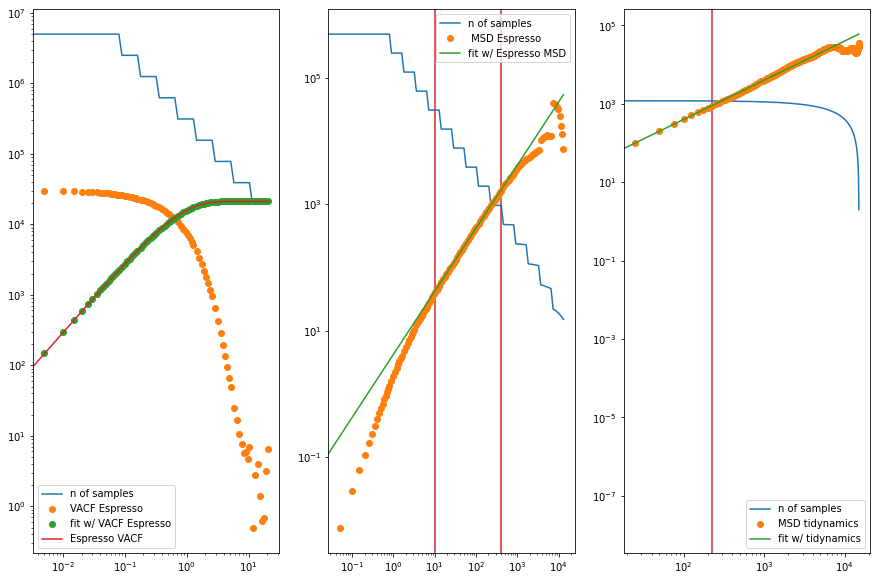

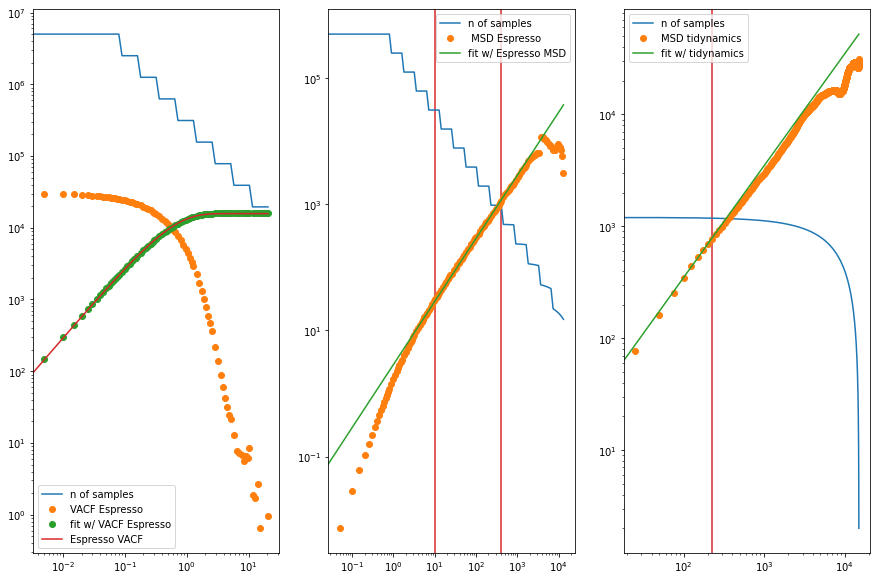

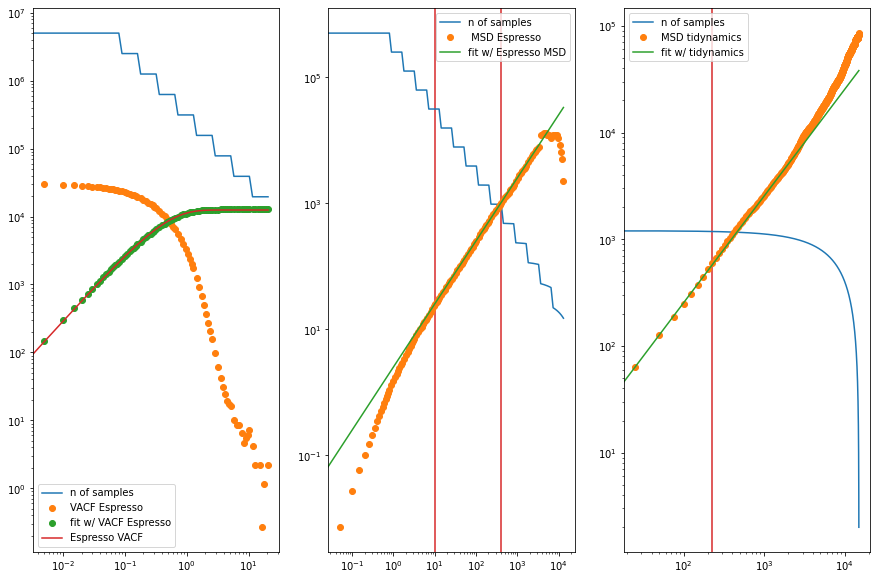

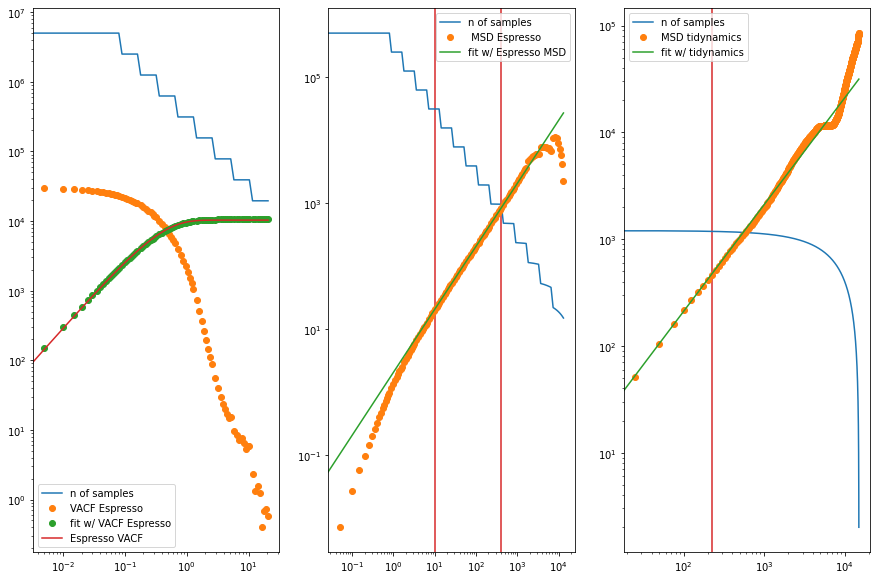

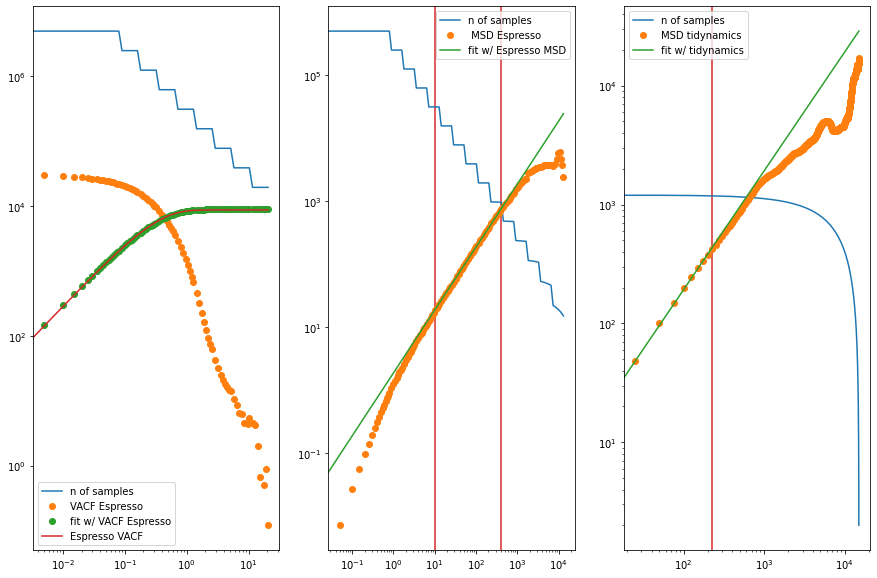

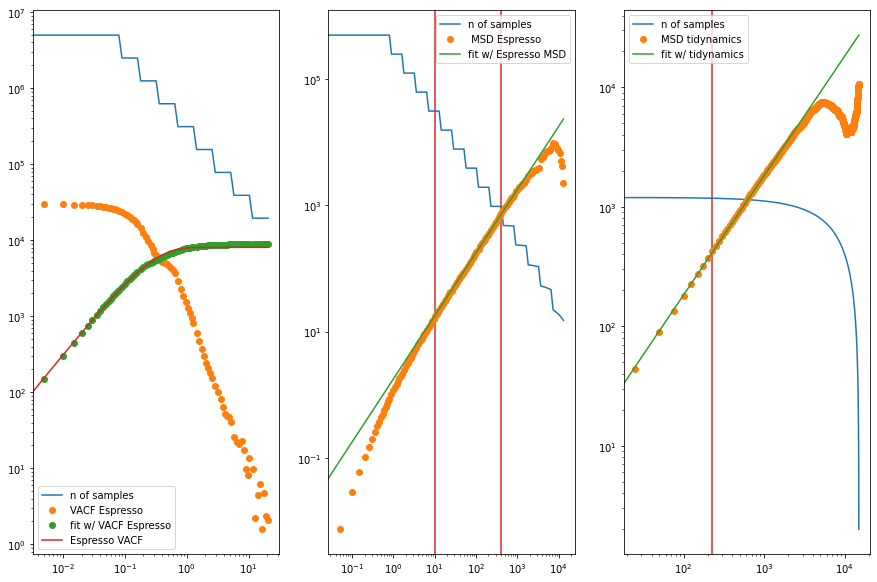

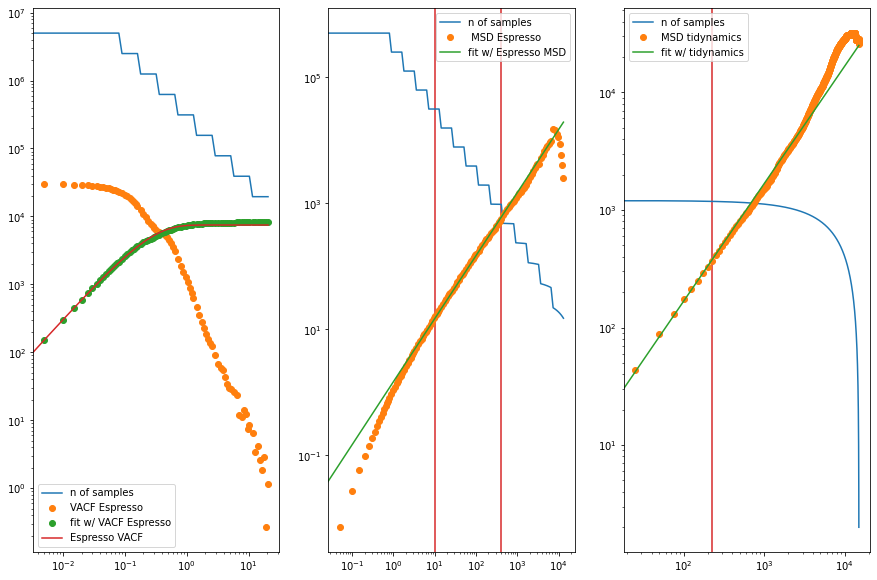

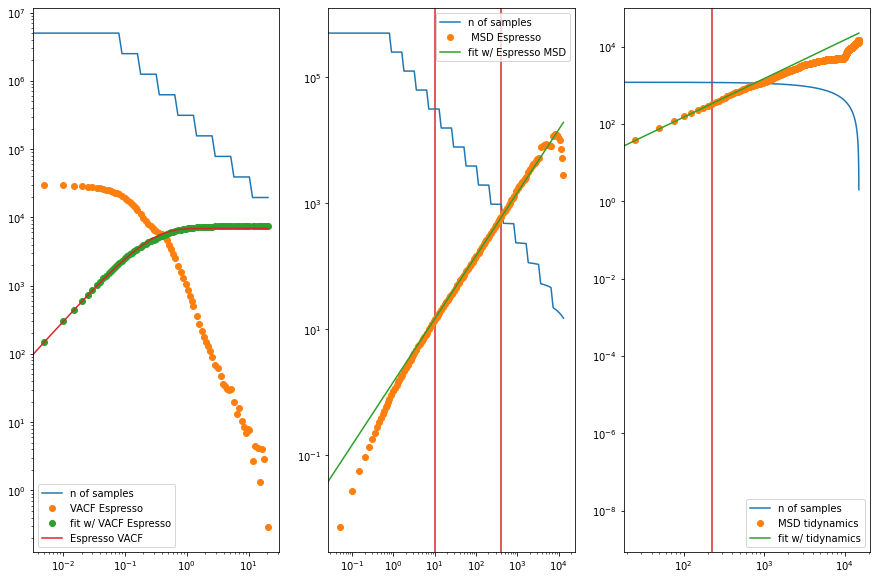

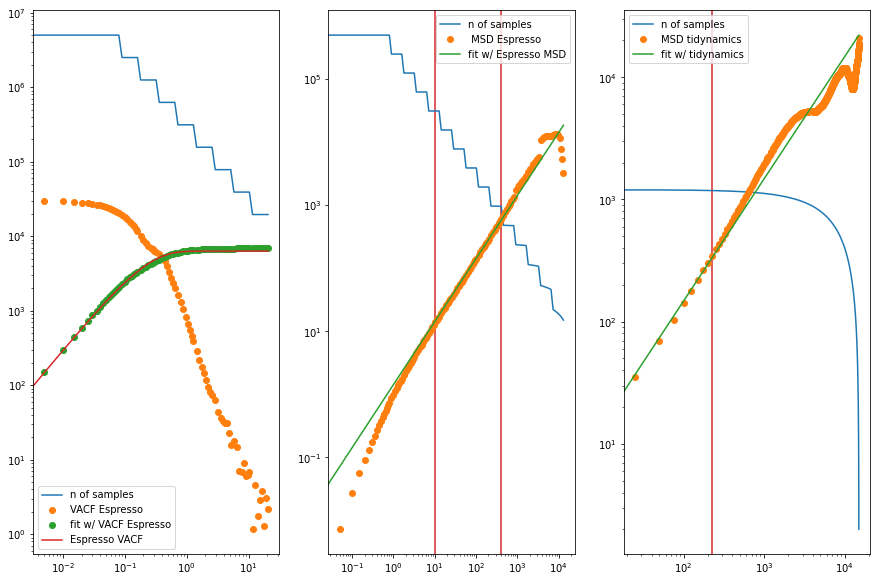

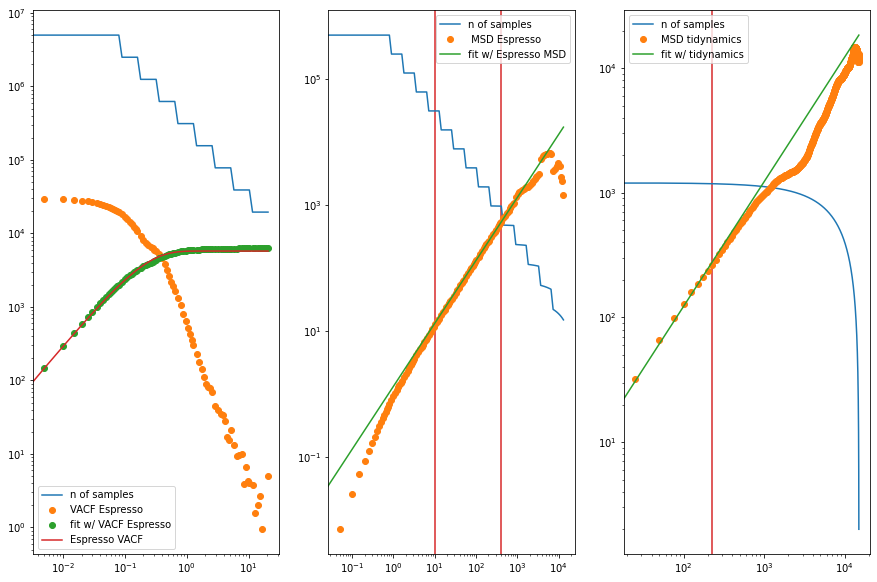

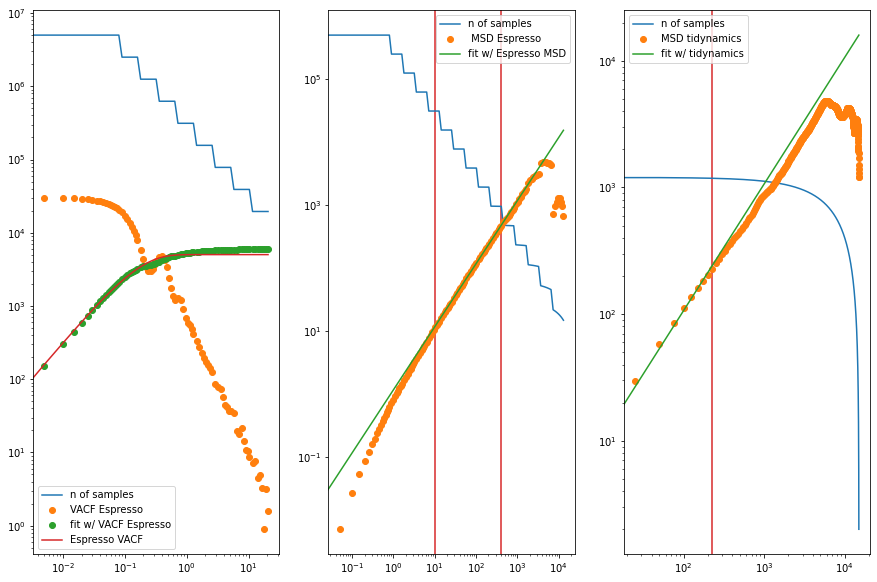

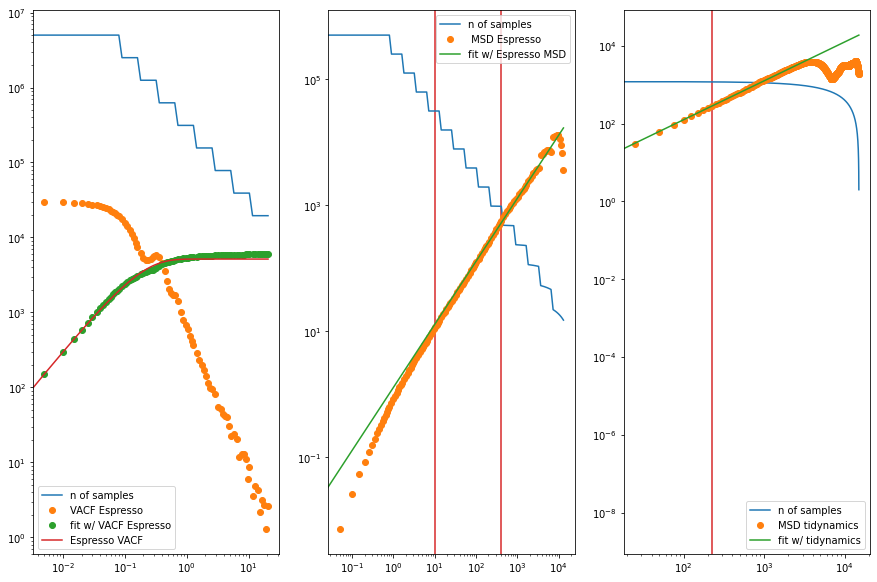

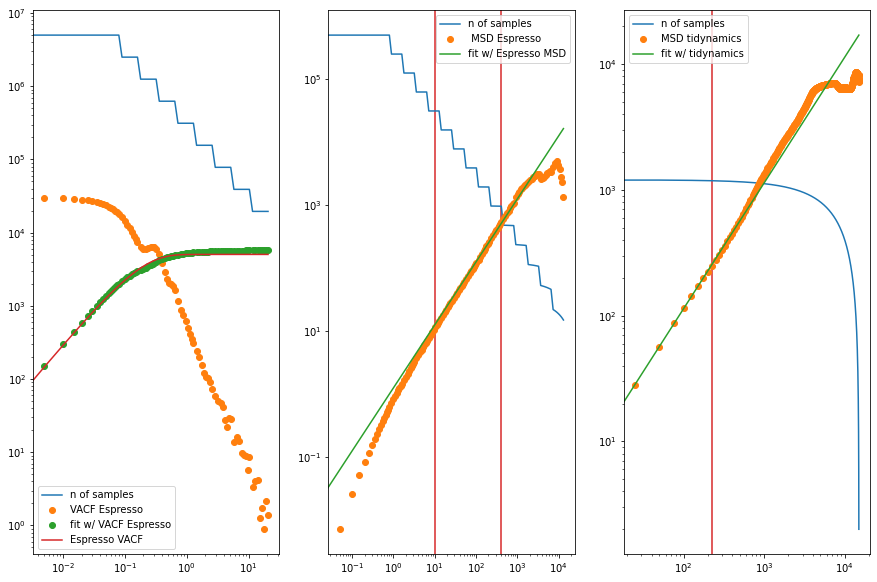

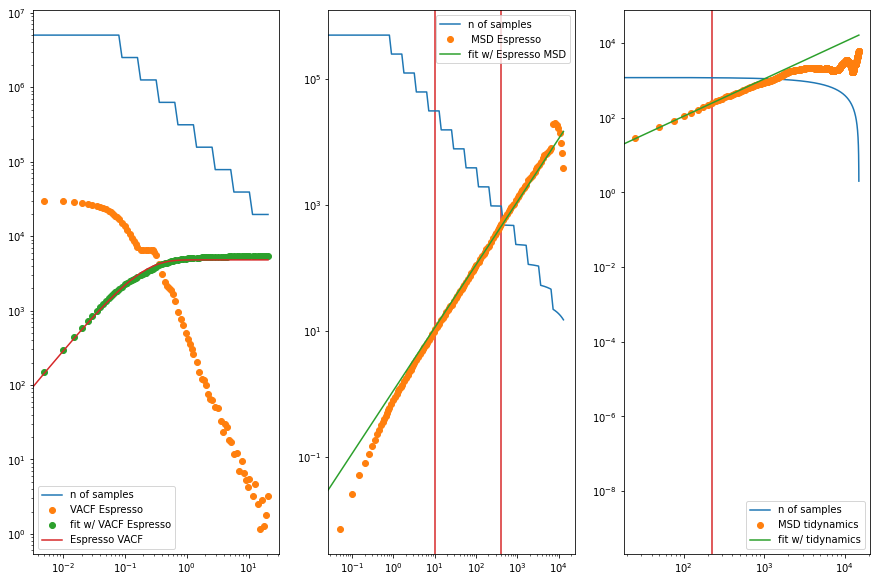

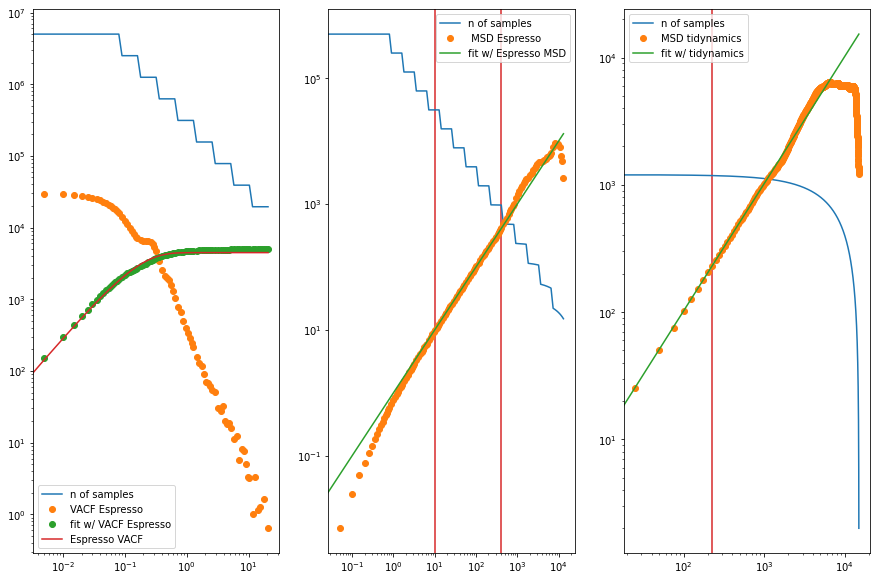

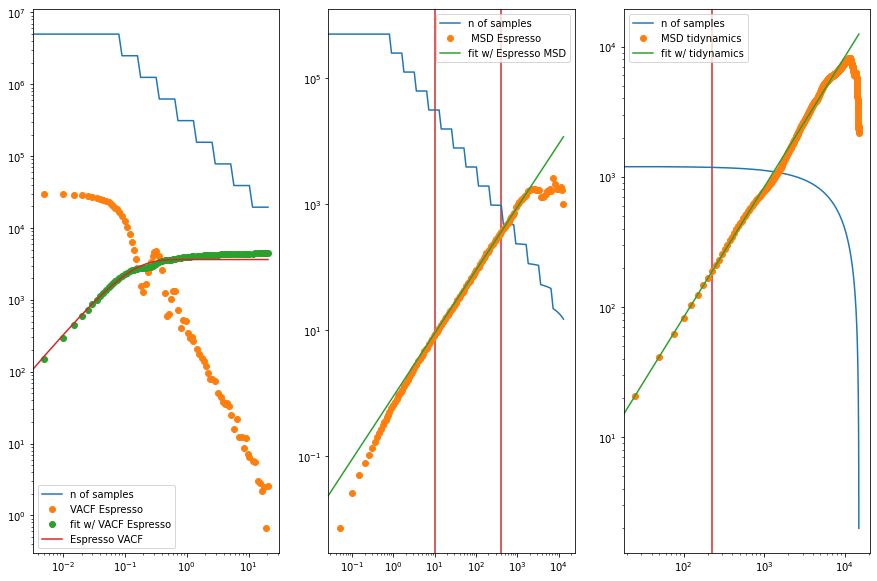

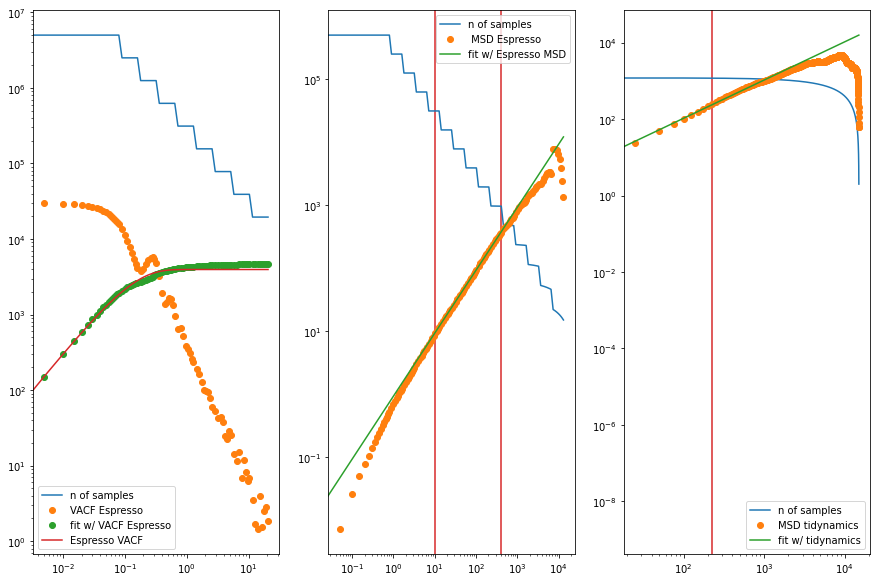

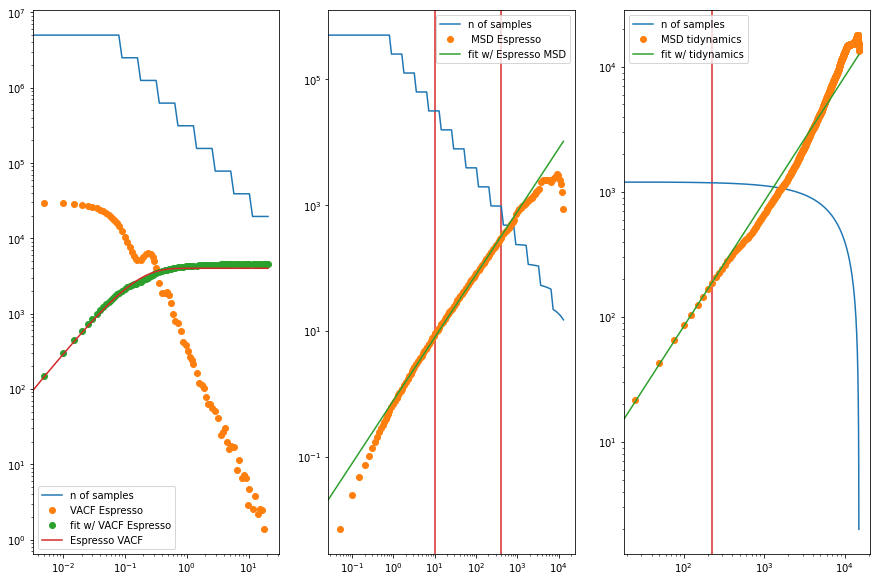

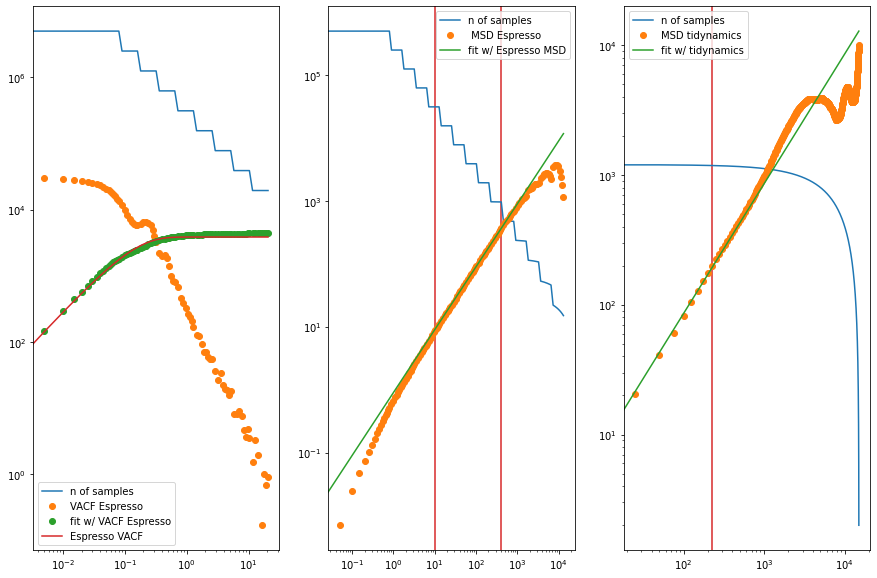

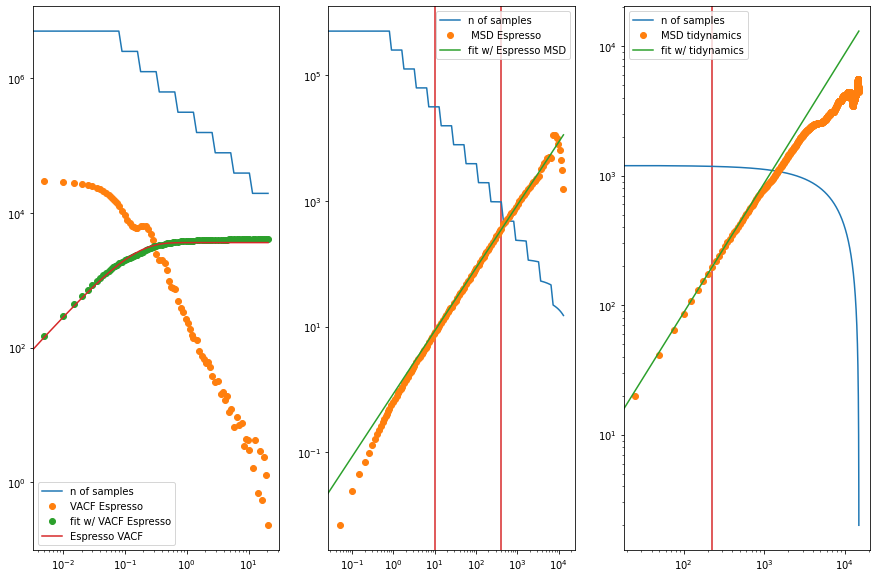

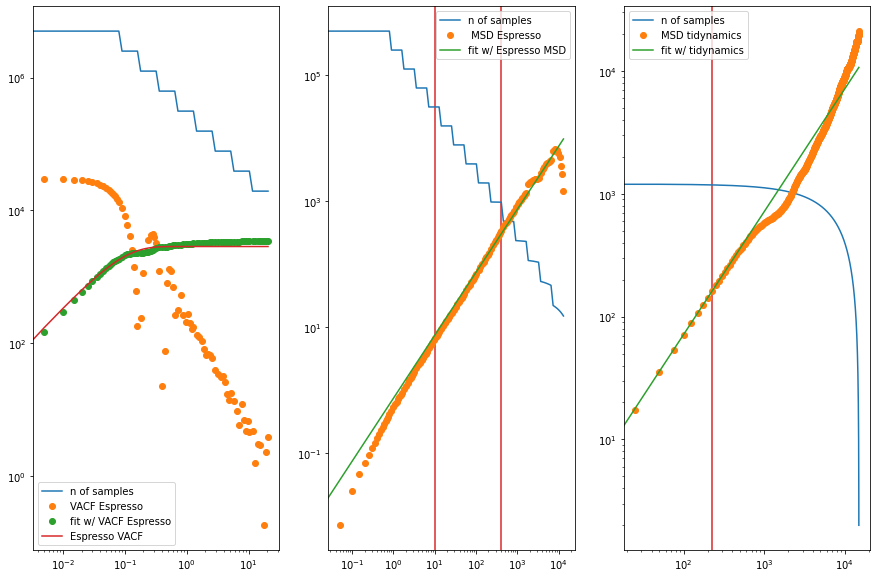

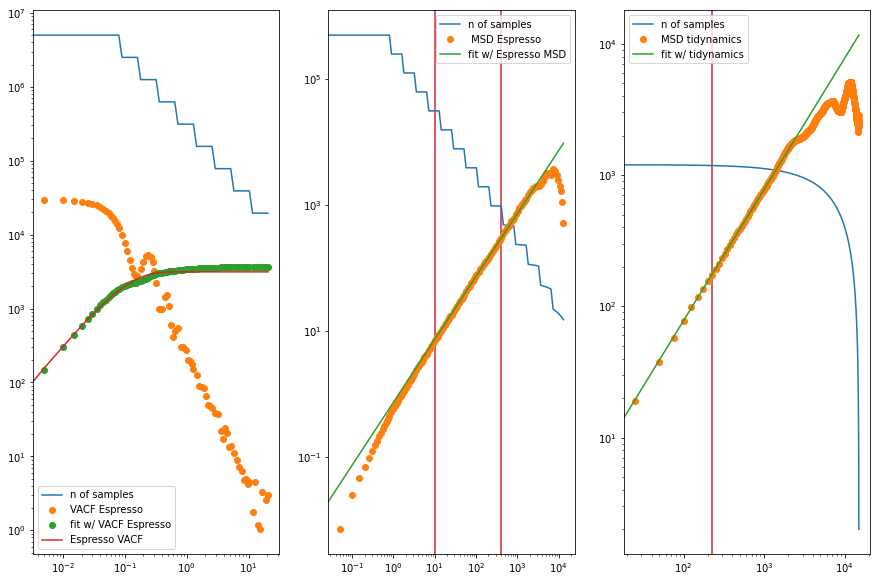

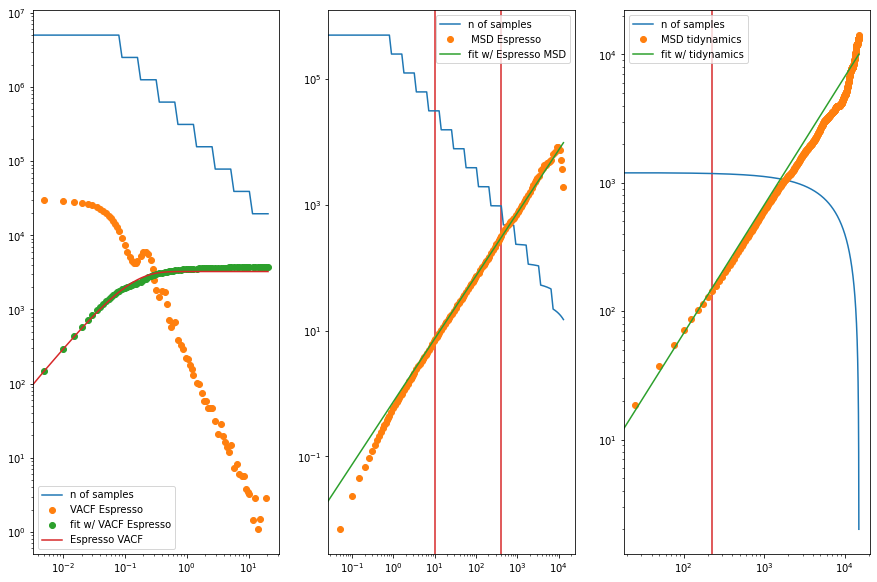

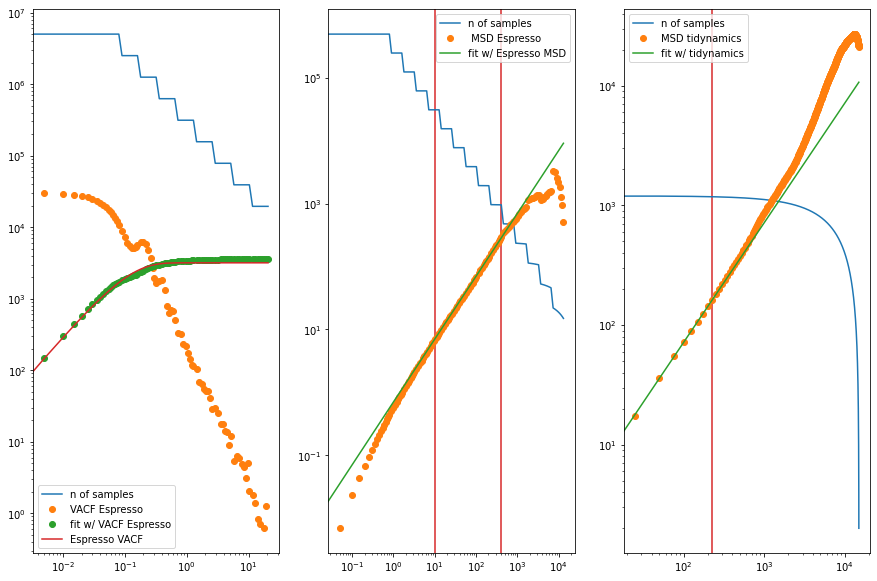

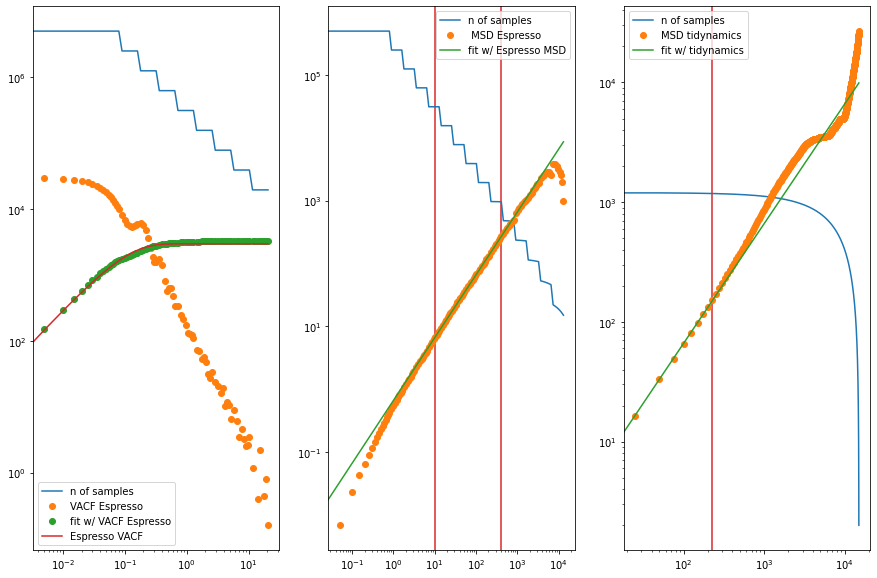

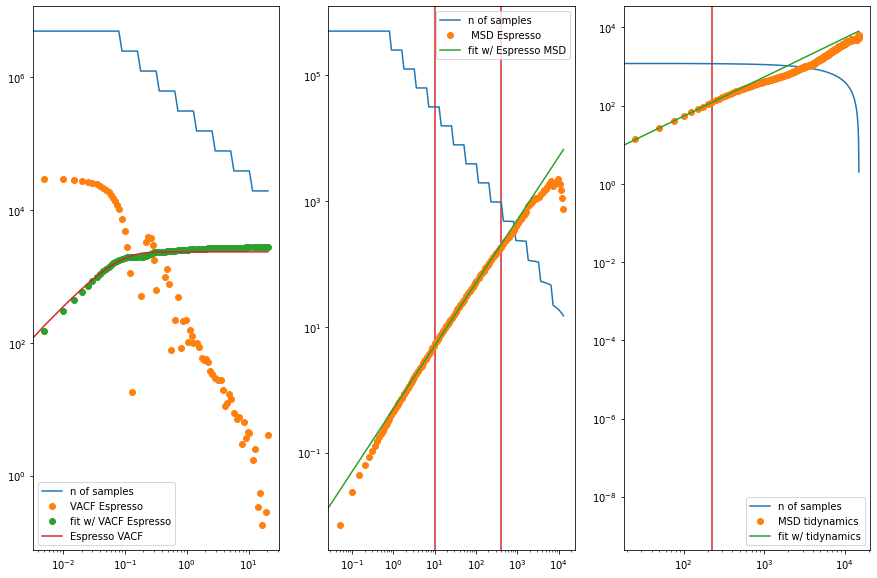

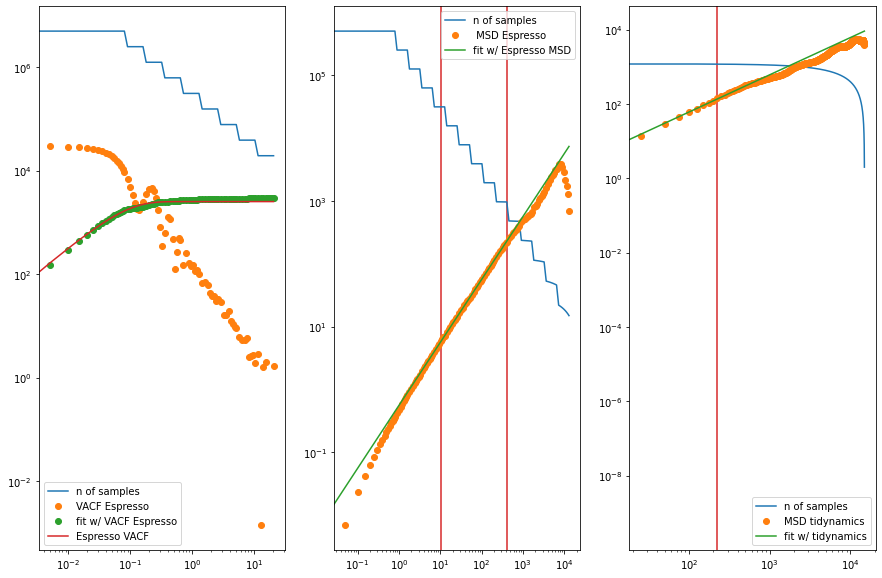

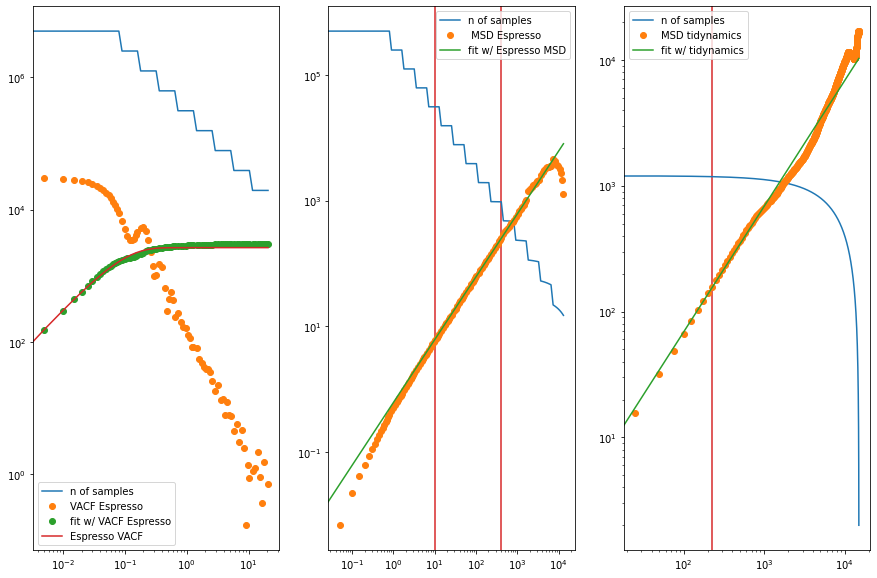

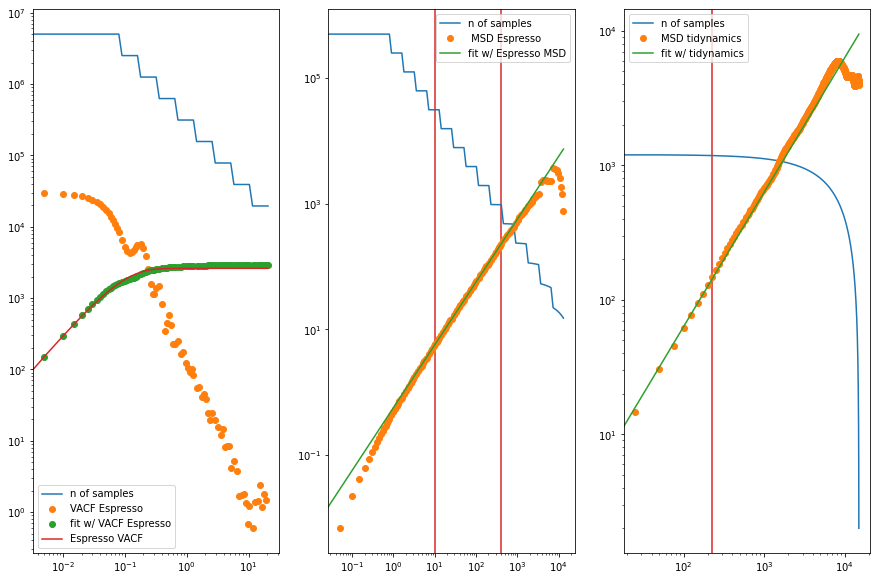

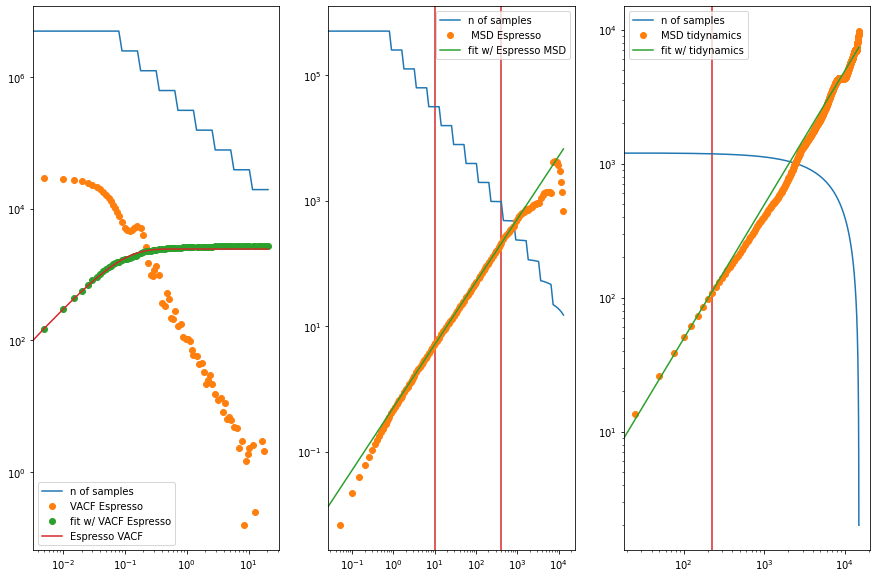

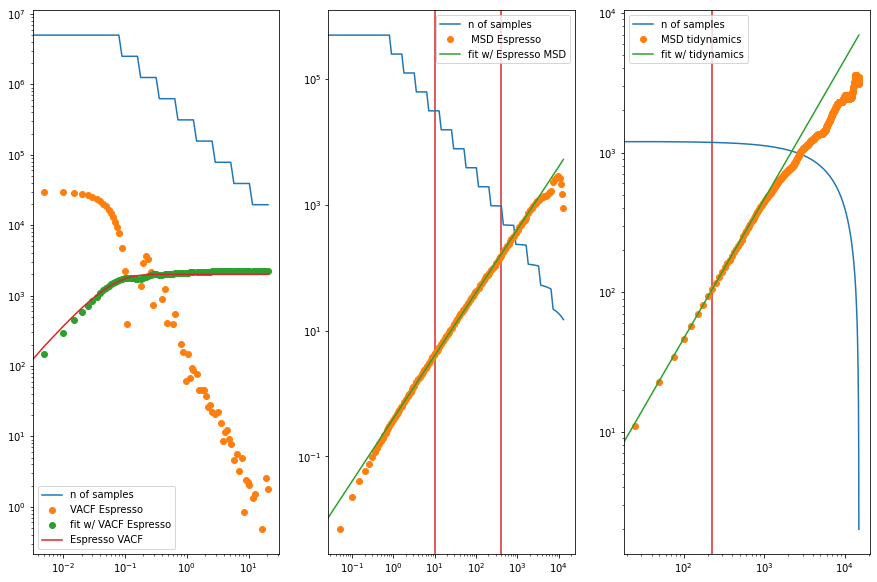

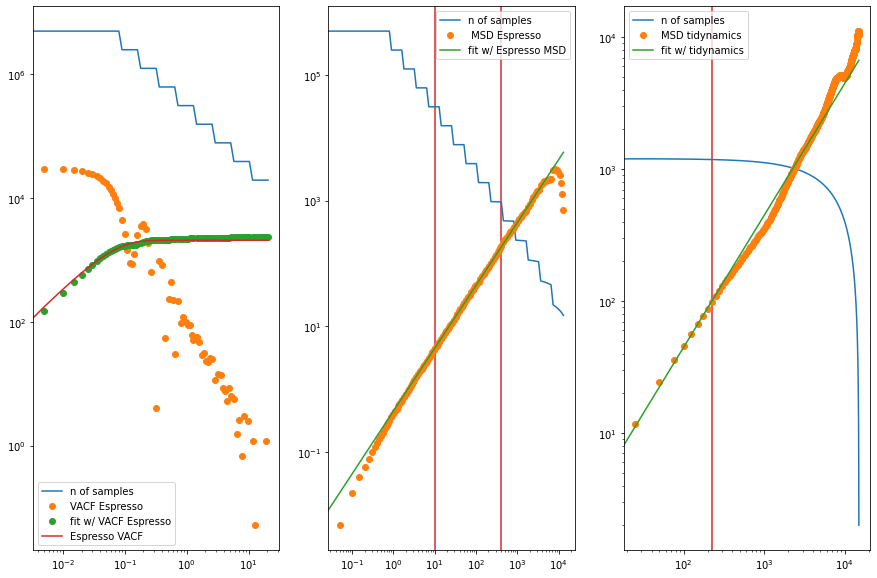

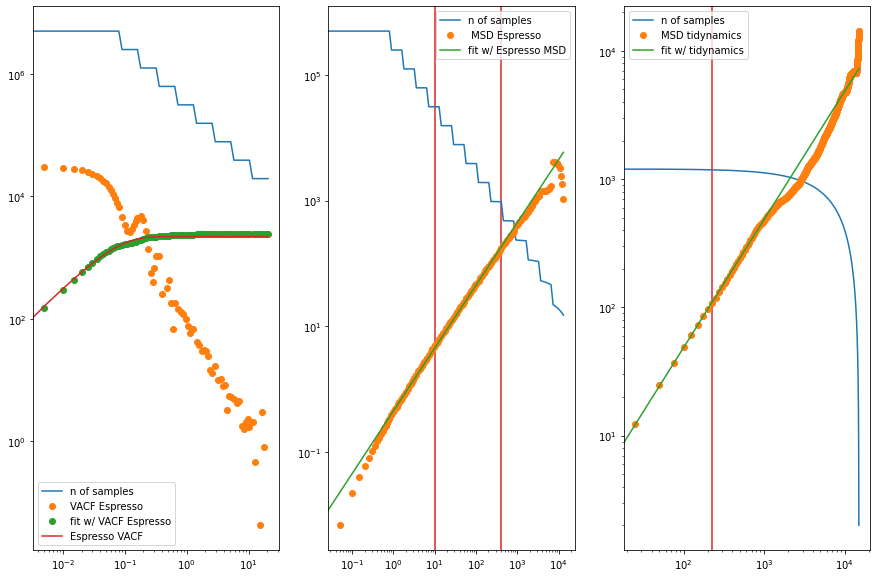

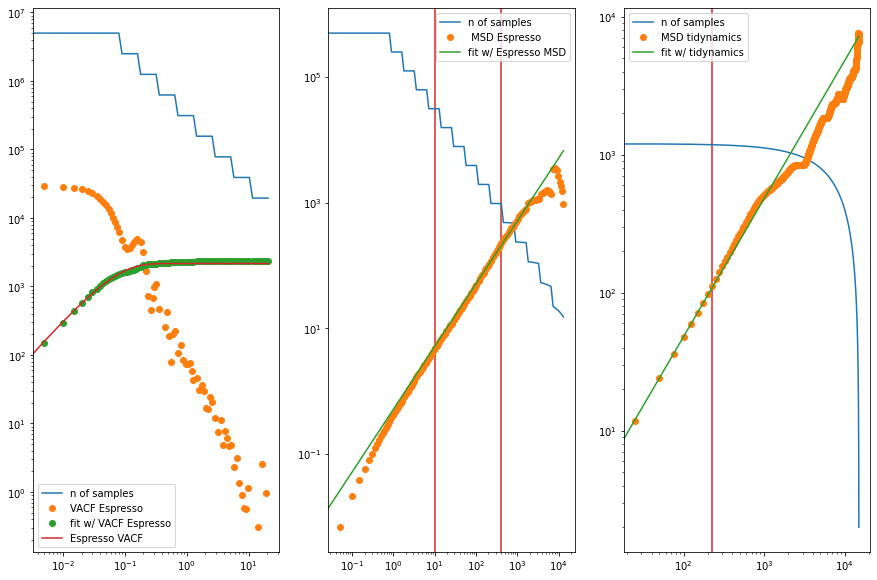

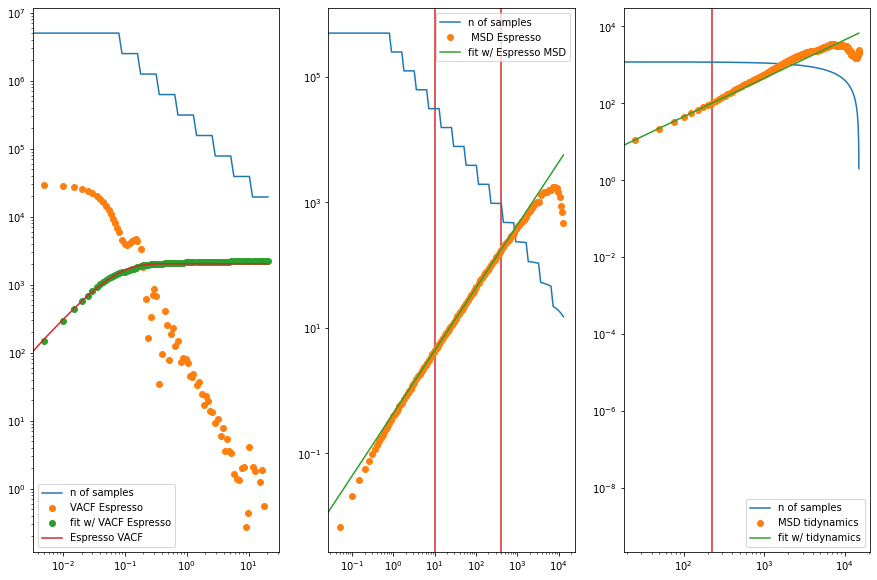

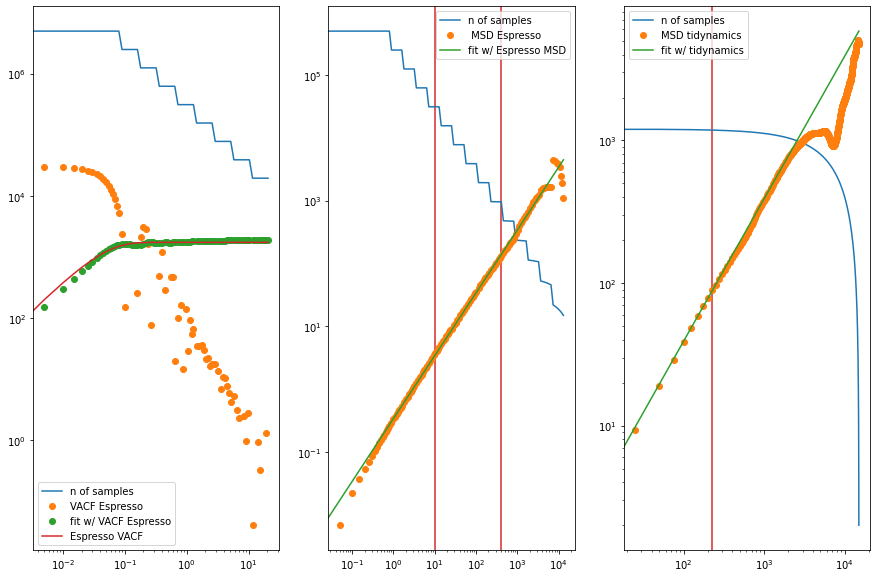

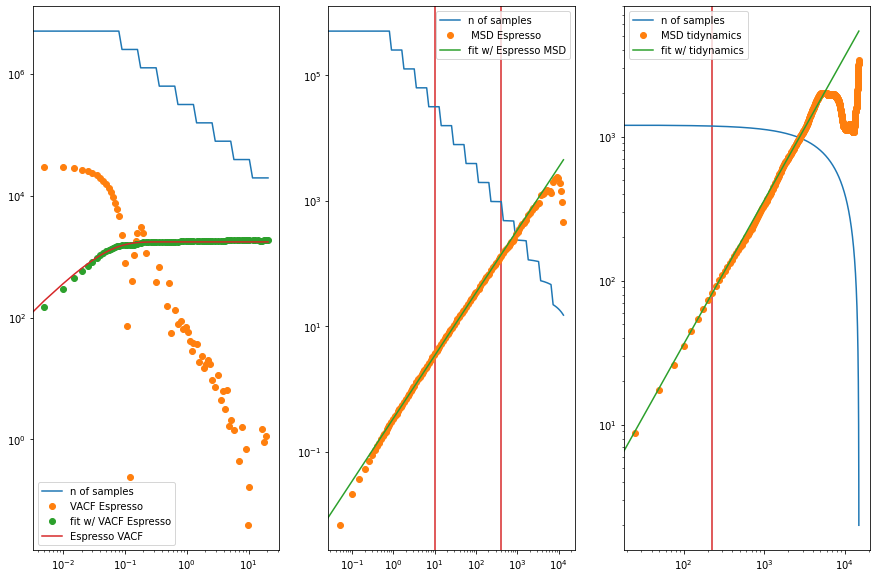

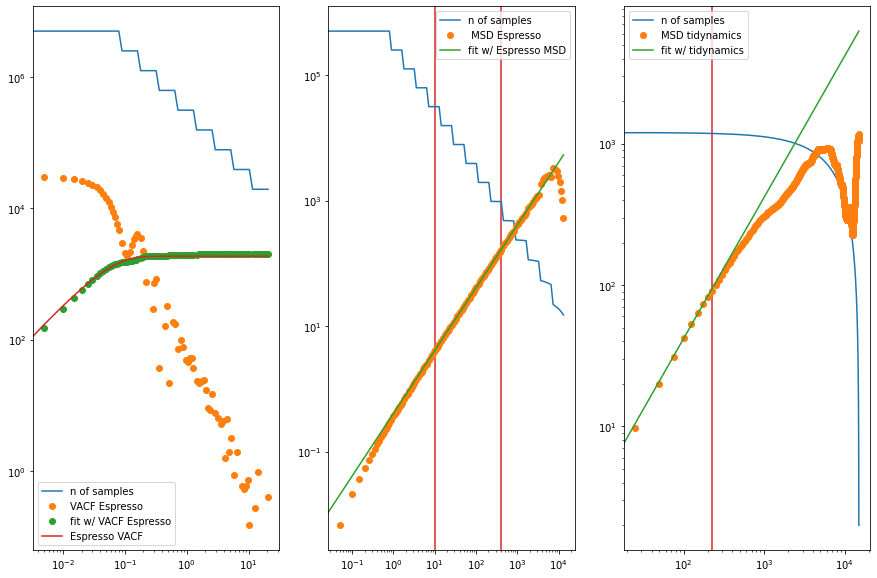

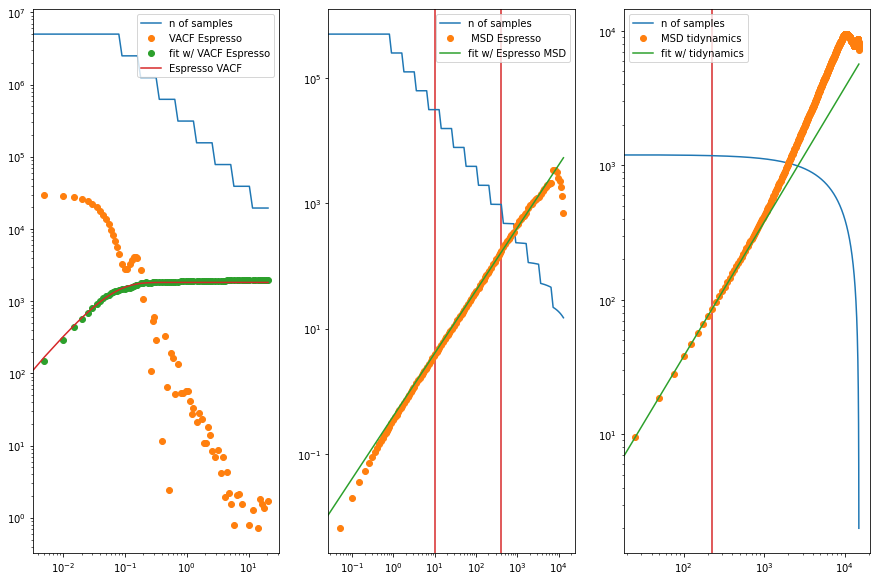

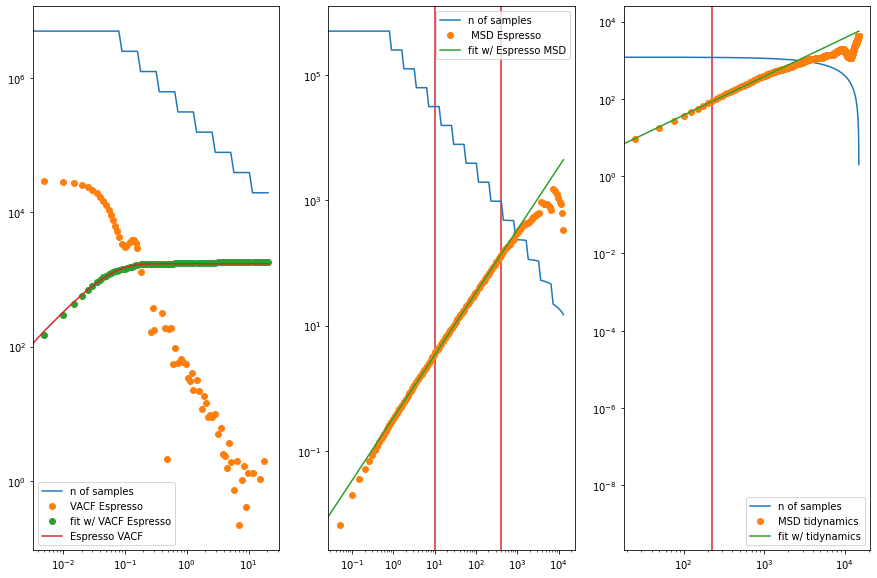

In [6]:
diff_coeff = np.empty([4,40])

for i in range(40):
    j = i+1
    
    with open('../parameter_files/params_dpd.csv') as f:
        line = f.readlines()[j]
        line = line.split(',')
        
    rho, a_ij = line[0], line[1]
    
    print('Density, rep force:', rho, a_ij)
    
    vacf = np.load(data_dir + 'dpd_diff_' + job_name + '[' + str(j) +']/dpd_sample_vacf.npy')
    msd = np.load(data_dir + 'dpd_diff_' + job_name + '[' + str(j) +']/dpd_sample_msd.npy')
    
    idx1 = np.searchsorted(msd[:,0], 10)
    idx2 = np.searchsorted(msd[:,0], 400)
    print('Indixes:', idx1, idx2)
    print('Time of indexes:', msd[idx1,0], msd[idx2,0])
    
    #print(np.shape(vacf))
    vel_acf_int = cumtrapz(vacf[:,2], x = vacf[:,0], initial = 0)
    D_vacf, pcov = curve_fit(vel_acf_fit,
                             vacf[:,0], vel_acf_int, 
                             sigma = 1/(np.sqrt(vacf[:,1]))
                             )

    #print(np.shape(msd))
    D_msd, pcov = curve_fit(meansqrdis, 
                            msd[idx1:idx2,0], msd[idx1:idx2,2] + msd[idx1:idx2,3] + msd[idx1:idx2,4], 
                            sigma = 1/(np.sqrt(msd[idx1:idx2,1]))
                            )

    plt.figure(figsize=(15,10))
    ax1 = plt.subplot(131)
    ax1.loglog(vacf[:,0],vacf[:,1], label='n of samples')
    ax1.loglog(vacf[:,0],vacf[:,2], 'o', label='VACF Espresso')
    ax1.loglog(vacf[:,0],vel_acf_int, 'o', label='fit w/ VACF Espresso')
    ax1.loglog(vacf[:,0],vel_acf_fit(vacf[:,0],*D_vacf), label='Espresso VACF')
    ax1.legend()

    ax2 = plt.subplot(132)
    ax2.axvline(x=msd[idx1,0], color='tab:red')
    ax2.axvline(x=msd[idx2,0], color='tab:red')
    ax2.loglog(msd[:,0],msd[:,1], label='n of samples')
    ax2.loglog(msd[:,0],msd[:, 2] + msd[:, 3] + msd[:, 4], 'o', label=' MSD Espresso')
    ax2.loglog(msd[:,0],meansqrdis(msd[:,0],D_msd), label='fit w/ Espresso MSD')
    ax2.legend()
    
    print('D from VACF, MSD:', 1/3*D_vacf[0]/10000, D_msd[0])
    
    h5file = h5py.File(data_dir + 'dpd_diff_' + job_name + '[' + str(j) +']/trajectory.h5', 'r')

    cutoff = 600
    weights = np.arange(2*cutoff, 0, -2)
    
    r = h5file['particles/atoms/position/value'][-cutoff:]
    vel = h5file['particles/atoms/velocity/value'][-cutoff:]
    image = h5file['particles/atoms/image/value'][-cutoff:]
    le_offset = h5file['particles/atoms/lees_edwards_offset/value'][-cutoff:]
    edges = h5file['particles/atoms/box/edges/'][:]
    r_time = h5file['particles/atoms/position/time'][-cutoff:]
    time = r_time-r_time[0]
    
    pos = r + image*edges[None,None,:]
    
    msd_traj = np.empty([cutoff, 10000])
    
    for k in range(10000):
        msd_traj[:,k] = tidynamics.msd(pos[:,1,:])

    msd_mean = np.mean(msd_traj, axis=1)
    
    idx1 = np.searchsorted(time, 0)
    idx2 = np.searchsorted(time, 200)
    print('Indixes:', idx1, idx2)
    print('Time of indexes:', time[idx1], time[idx2])
        
    D_msd_traj, pcov = curve_fit(meansqrdis, 
                            time[idx1:idx2], msd_mean[idx1:idx2],
                            sigma = 1/(np.sqrt(weights[idx1:idx2]))
                            )
    
    ax3 = plt.subplot(133)
    ax3.axvline(x=time[idx1], color='tab:red')
    ax3.axvline(x=time[idx2], color='tab:red')
    ax3.loglog(time, weights, label='n of samples')
    ax3.loglog(time,msd_mean,'o', label='MSD tidynamics')
    ax3.loglog(time,meansqrdis(time,D_msd_traj), label='fit w/ tidynamics')
    ax3.legend()
    
    print('D from tidynamics:', D_msd_traj[0])
    
    diff_coeff[:,i] = rho, a_ij, D_msd_traj[0], D_msd[0]
    

[[3.00000000e+00 4.00000000e+00 5.00000000e+00 6.00000000e+00
  7.00000000e+00 3.00000000e+00 4.00000000e+00 5.00000000e+00
  6.00000000e+00 7.00000000e+00 3.00000000e+00 4.00000000e+00
  5.00000000e+00 6.00000000e+00 7.00000000e+00 3.00000000e+00
  4.00000000e+00 5.00000000e+00 6.00000000e+00 7.00000000e+00
  3.00000000e+00 4.00000000e+00 5.00000000e+00 6.00000000e+00
  7.00000000e+00 3.00000000e+00 4.00000000e+00 5.00000000e+00
  6.00000000e+00 7.00000000e+00 3.00000000e+00 4.00000000e+00
  5.00000000e+00 6.00000000e+00 7.00000000e+00 3.00000000e+00
  4.00000000e+00 5.00000000e+00 6.00000000e+00 7.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.50000000e+01 2.50000000e+01 2.50000000e+01
  2.50000000e+01 2.50000000e+01 5.00000000e+01 5.00000000e+01
  5.00000000e+01 5.00000000e+01 5.00000000e+01 7.50000000e+01
  7.50000000e+01 7.50000000e+01 7.50000000e+01 7.50000000e+01
  1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
  1.000

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


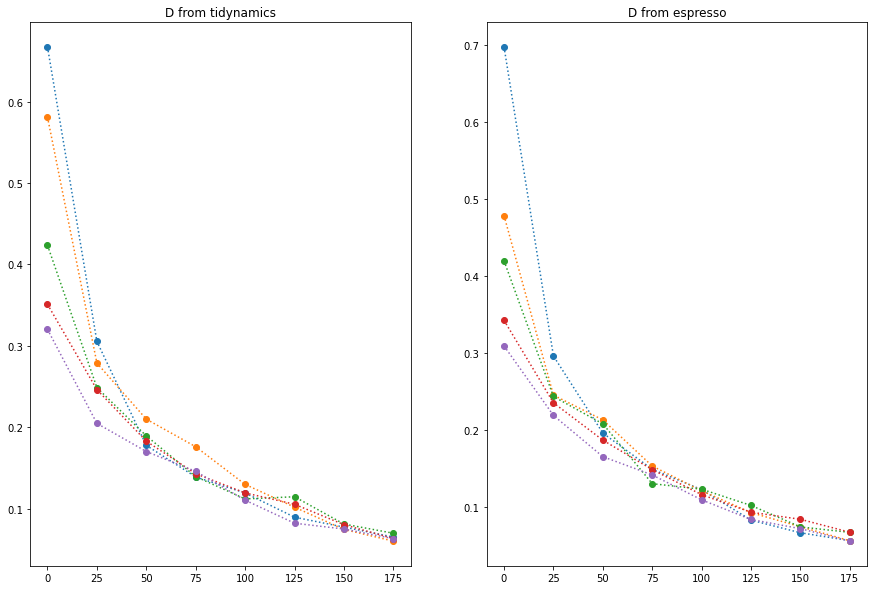

In [7]:
#np.save('diffcoeff_' + job_name, diff_coeff)
    
print(diff_coeff)
plt.figure(figsize=(15,10))
    
selection = [0, 5, 10, 15, 20, 25, 30, 35]
selection = np.array(selection)

ax1 =plt.subplot(121)
for i in range(5):
    ax1 =plt.subplot(121)
    ax1.plot(diff_coeff[1,selection], diff_coeff[2,selection], 'o:')
    ax1.set_title("D from tidynamics")
    ax2 =plt.subplot(122)
    ax2.plot(diff_coeff[1,selection], diff_coeff[3,selection], 'o:')
    ax2.set_title("D from espresso")
    selection += 1